# Importings

In [32]:
import pandas as pd                                    # for data
import numpy as np                                     # for math
from lightgbm import LGBMRegressor                     # Validation model
from sklearn.metrics import mean_squared_error         # Regressortion metric
from sklearn.model_selection import GroupKFold,KFold, TimeSeriesSplit   # for validation
from sklearn.preprocessing import LabelEncoder         # for encoding
import sklearn.manifold._t_sne as tsne                 # for t_sne
import seaborn as sns                     
from sklearn.model_selection import TimeSeriesSplit# for plotting
import matplotlib.pyplot as plt    
from statsmodels.graphics.tsaplots import plot_acf
from matplotlib import rcParams
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import rankdata
import xgboost as xgb 
from sklearn.cluster import KMeans
train = pd.read_csv('/Users/ahmed/Downloads/computerscience/Kaggle/geoai-ground-level-no2-estimation/geoai-ground/data/Train.csv') 
test = pd.read_csv('/Users/ahmed/Downloads/computerscience/Kaggle/geoai-ground-level-no2-estimation/geoai-ground/data/Test.csv')
groups = train['ID']
test_id = test['ID_Zindi']
pd.options.display.max_columns = 200


In [33]:
def post_process(test_data,y,feature_to_mean='Month') -> int:
    test_data['target'] = y
    test_data['target_month'] = test_data[feature_to_mean].map(test_data[[feature_to_mean,'target']].groupby(feature_to_mean)['target'].mean())
    test_data.drop(columns='target',inplace=True)
    return test_data['target_month']

In [57]:
train = train[train.loc[train['Precipitation'] > 100.0] = 0]


SyntaxError: cannot assign to subscript here. Maybe you meant '==' instead of '='? (1752054080.py, line 1)

In [48]:
test.describe()

,LAT,LON,Precipitation,LST,AAI,CloudFraction,NO2_strat,NO2_total,NO2_trop,TropopausePressure
count,6576.000000,6576.000000,6576.000000,3595.000000,5708.000000,5708.000000,5708.000000,5708.000000,3998.000000,5708.000000
mean,45.363205,10.489789,2.544018,299.394019,-1.273390,0.203512,0.000045,0.000135,0.000081,16673.339355
std,0.260667,1.306469,7.475326,11.034047,0.691949,0.269866,0.000012,0.000084,0.000067,3007.160286
min,45.131947,8.842165,0.000000,254.720000,-3.716866,0.000000,0.000013,0.000006,-0.000009,8614.512125
25%,45.151743,9.146666,0.000000,291.040000,-1.753032,0.013360,0.000034,0.000094,0.000041,14433.046735
50%,45.237853,10.398575,0.000000,300.900000,-1.363993,0.070884,0.000047,0.000111,0.000058,16714.003425
75%,45.582894,11.642394,0.000000,308.120000,-0.876478,0.296377,0.000056,0.000144,0.000097,19260.483658
max,45.836941,12.510362,103.227943,324.140000,2.474583,1.000000,0.000072,0.001454,0.000960,24424.343390


In [43]:
train[train['ID'].isin(['PD03', 'TV03', 'X5561', 'X5953', 'X6701', 'X6877'])]

,ID_Zindi,Date,ID,LAT,LON,Precipitation,LST,AAI,CloudFraction,NO2_strat,NO2_total,NO2_trop,TropopausePressure,GT_NO2


# Feature Engineering

In [ ]:
"""train = train.sort_values('Date').reset_index(drop=True) 
test = test.sort_values('Date').reset_index(drop=True)
"""
for df in (train,test):
    df['Date'] = pd.to_datetime(df['Date'])
    #df['Day'] =  df['Date'].dt.day
    df['Month'] = df['Date'].dt.month
    #df['target_month'] = df['Month'].map(df[['Month','GT_NO2']].groupby('Month')['GT_NO2'].mean())
    #df['Month'] = df['Date'].dt.is_month_start
    #df['Year'] =  df['Date'].dt.year
    #df.set_index(df['Date'],inplace=True)
    #df['DayOfWeek'] =  df['Date'].dt.dayofweek
    df.drop(columns=['ID_Zindi'],inplace=True)
    
#Lags
#for df in(train,test): 
    #df['Precipitation_inter1'] = df['TropopausePressure'] + df['Precipitation']
    #df['Precipitation_log'] =  np.log(df['Precipitation'] + 1e-9)
    #df['CloudFraction_diff'] = df['CloudFraction'] / df['NO2_strat']
    #df['CloudFraction_diff2'] = df['CloudFraction'] / df['NO2_total']
    #['Precipitation_fractional'] = df['Precipitation'] * 0.00001
    #df['TropopausePressure_fractional'] = round(df['TropopausePressure'] * 0.00001,2)
    #df['cluster'] = kmeans.fit_transform(df[['LAT', 'LON']])
    #df['cloud_fraction1'] = df['CloudFraction'] % df['NO2_strat']
    #df['cloud_fraction1'] = df['CloudFraction'] % df['NO2_total']

#for df in(train,test): 
    #Rolling (Moving Average)
    #df['feature_rolling_3_mean'] = df['TropopausePressure'].rolling(5).mean()
    #df['feature_rolling_7_mean'] = df['TropopausePressure'].rolling(7).mean()
    #df['feature_rolling_7_std'] = df['TropopausePressure'].rolling(7).std()
    #df['NO2_strat_rolling7'] = df['NO2_strat'].rolling(7).mean()
    #df['NO2_strat_rolling30'] = df['NO2_strat'].rolling(30).mean()
    #df['NO2_strat_rolling2'] = df['NO2_strat'].rolling(9).mean()
#statsitics of similar variables

"""def MeanSd(feature1, feature2):
    for dataset in (train,test):
        dataset["SD" + feature1] = dataset[[feature1,feature2]].std(axis=1)
        dataset["MEAN" + feature1] = dataset[[feature1,feature2]].mean(axis=1)

MeanSd('NO2_trop','NO2_total')
MeanSd('LON','LAT')"""

/var/folders/4c/h16036bx2ync7wqkqvrl2p1h0000gn/T/ipykernel_8307/1927459310.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'])
/var/folders/4c/h16036bx2ync7wqkqvrl2p1h0000gn/T/ipykernel_8307/1927459310.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'])


'def MeanSd(feature1, feature2):\n    for dataset in (train,test):\n        dataset["SD" + feature1] = dataset[[feature1,feature2]].std(axis=1)\n        dataset["MEAN" + feature1] = dataset[[feature1,feature2]].mean(axis=1)\n\nMeanSd(\'NO2_trop\',\'NO2_total\')\nMeanSd(\'LON\',\'LAT\')'

In [ ]:
#for df in(train,test): 
    #df['LST_mean_60'] = df['LST'].rolling(60).mean()
    #df['Prec_mean_60'] = df['Precipitation'].rolling(60).mean()
    #df['AII_mean'] = df['AAI'].rolling(60).mean()
    #df['no2_total'] = df['NO2_total'].rolling(60).min()

    #df['feature_rolling_3_mean'] = df['TropopausePressure'].rolling(5).mean()
    #df['feature_rolling_7_mean'] = df['TropopausePressure'].rolling(7).mean()
    #df['feature_rolling_7_std'] = df['TropopausePressure'].rolling(7).std()
    #df['NO2_strat_rolling7'] = df['NO2_strat'].rolling(7).mean()
    #df['NO2_strat_rolling30'] = df['NO2_strat'].rolling(30).mean()
    #df['NO2_strat_rolling2'] = df['NO2_strat'].rolling(9).mean()


def rolling(feature):
    for dataset in (train,test):
        #dataset[f"{feature}_rolling_mean_60"] = dataset[feature].rolling(60).mean()
        dataset[f"{feature}_rolling_max_60"] = dataset[feature].rolling(60).max()
        #dataset[f"{feature}_rolling_min_60"] = dataset[feature].rolling(60).min()


rolling('NO2_trop')
rolling('NO2_total')
rolling('TropopausePressure')
rolling('CloudFraction')
#rolling('AAI')
#rolling('LST')
rolling('Precipitation')

# Missing Values & Encoding

In [ ]:
groups = train['ID']
for df in(train,test):
    df.drop(columns=["Date"], axis=1,inplace=True)
le = LabelEncoder()
for df in(train,test): 
    for col in df.columns: 
        if df[col].dtype == 'object': 
            df[col] = le.fit_transform(df[col])

# CV and Modeling

In [ ]:
#groups = train['ID']
model =  LGBMRegressor(random_state=7)
n_splits = 5
n = train['GT_NO2'].count()
num_bins = int(1 + np.log2(n))
#train['GT_NO2_bins'] = pd.cut(train['GT_NO2'], bins=num_bins, labels=False)
#test['GT_NO2_bins'] = pd.cut(test['GT_NO2'], bins=num_bins, labels=False)

In [ ]:

n_splits = 7
cv = GroupKFold(n_splits=n_splits)
train = train[['NO2_strat', 'NO2_total', 'NO2_trop', 'TropopausePressure', 'GT_NO2']]
test = test[['NO2_strat', 'NO2_total', 'NO2_trop', 'TropopausePressure']]
def validate(trainset, testset, target_col):

    model.fit(trainset.drop(columns=target_col), trainset[target_col])
    pred = model.predict(testset.drop(columns=target_col))
    valid_idx = testset[target_col].notna()
    valid_testset = testset[target_col][valid_idx]
    valid_pred = pred[valid_idx]
    print('std:', valid_testset.std())
    score = mean_squared_error(valid_testset, valid_pred, squared=False)
    print('score:', score)
    
    return score
stds = []
rmse = []

for train_idx, test_idx in cv.split(train.drop(columns='GT_NO2'), train['GT_NO2'], groups=groups):
    train_v, test_v = train.iloc[train_idx], train.iloc[test_idx]
    stds.append(test_v['GT_NO2'].std())
    rmse.append(validate(train_v, test_v, 'GT_NO2'))

print('RMSE:', np.array(rmse).mean())
print('RMSE std:', np.array(rmse).std())
print('Standard Deviations:', stds)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001760 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 73432, number of used features: 4
[LightGBM] [Info] Start training from score 22.947247
std: 18.17039326297426
score: 14.478139165567367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000249 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 73432, number of used features: 4
[LightGBM] [Info] Start training from score 23.608344
std: 13.449154151195614
score: 10.152123540868873


/Users/ahmed/Downloads/computerscience/Kaggle/geoai-ground-level-no2-estimation/geoai-ground/venv-geoai-ground-level-no2-estimation/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/ahmed/Downloads/computerscience/Kaggle/geoai-ground-level-no2-estimation/geoai-ground/venv-geoai-ground-level-no2-estimation/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004095 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 74528, number of used features: 4
[LightGBM] [Info] Start training from score 22.876272
std: 18.340023119076278
score: 12.582331830362191
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000217 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 74528, number of used features: 4
[LightGBM] [Info] Start training from score 23.128862


/Users/ahmed/Downloads/computerscience/Kaggle/geoai-ground-level-no2-estimation/geoai-ground/venv-geoai-ground-level-no2-estimation/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


std: 16.80005938565427
score: 11.419647087072759
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000423 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 74528, number of used features: 4
[LightGBM] [Info] Start training from score 23.182723
std: 18.52859596885474
score: 13.274535114519244


/Users/ahmed/Downloads/computerscience/Kaggle/geoai-ground-level-no2-estimation/geoai-ground/venv-geoai-ground-level-no2-estimation/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/ahmed/Downloads/computerscience/Kaggle/geoai-ground-level-no2-estimation/geoai-ground/venv-geoai-ground-level-no2-estimation/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000220 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 74528, number of used features: 4
[LightGBM] [Info] Start training from score 23.569752
std: 16.103576285616374
score: 11.225756794273899
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000315 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 74528, number of used features: 4
[LightGBM] [Info] Start training from score 23.441437


/Users/ahmed/Downloads/computerscience/Kaggle/geoai-ground-level-no2-estimation/geoai-ground/venv-geoai-ground-level-no2-estimation/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


std: 17.308240414323457
score: 11.977869148166668
RMSE: 12.158628954404431
RMSE std: 1.3244934910294908
Standard Deviations: [np.float64(18.17039326297426), np.float64(13.449154151195614), np.float64(18.340023119076278), np.float64(16.80005938565427), np.float64(18.52859596885474), np.float64(16.103576285616377), np.float64(17.308240414323457)]


/Users/ahmed/Downloads/computerscience/Kaggle/geoai-ground-level-no2-estimation/geoai-ground/venv-geoai-ground-level-no2-estimation/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
rmse

[np.float64(14.478139165567367),
 np.float64(10.152123540868873),
 np.float64(12.582331830362191),
 np.float64(11.419647087072759),
 np.float64(13.274535114519244),
 np.float64(11.225756794273899),
 np.float64(11.977869148166668)]

In [ ]:
#11.581549939504997 with month , 
#12.246931687286574
#12.235259341356834
#12.231869616518921
#12.126333476852636
#11.728753513719479
#11.724263538742687
#11.728753513719479 
#11.711277895239192
#11.694341231865433
#11.671982426722977
#11.642227859275334 without the mean - with the custamized means of rolling
#11.314985626750522 
#11.314985626750522
#11.312413659993586
#11.135932399851725 
#11.728753513719479 best so far features = ['LAT', 'Month','NO2_trop_rolling_max_60','NO2_total_rolling_max_60','TropopausePressure_rolling_max_60','CloudFraction_rolling_max_60','Precipitation_rolling_max_60']
#11.40320255907346 with the ID LB = 9.571700669
#11.597286160951526 the distance feature

In [ ]:
hshsd

NameError: name 'hshsd' is not defined

In [ ]:
model.fit(train.drop(columns='GT_NO2'),train['GT_NO2'])
y = model.predict(test)
smaple = pd.read_csv('/Users/ahmed/Downloads/computerscience/Kaggle/geoai-ground-level-no2-estimation/geoai-ground/data/SampleSubmission.csv')
smaple['GT_NO2'] = post_process(test,y)
smaple.to_csv('submissionpost2.csv',index=False)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002423 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3464
[LightGBM] [Info] Number of data points in the train set: 86584, number of used features: 16
[LightGBM] [Info] Start training from score 23.250548


In [ ]:
model.fit(train.drop(columns='GT_NO2'),train['GT_NO2'])
y_pred = model.predict(test)
sub_df = pd.DataFrame({'id': test_id,'GT_NO2':y_pred})
sub_df.to_csv('/Users/ahmed/Downloads/computerscience/Kaggle/geoai-ground-level-no2-estimation/geoai-ground/submissions/submission1140320255907346.csv', index=False)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009118 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3543
[LightGBM] [Info] Number of data points in the train set: 86584, number of used features: 17
[LightGBM] [Info] Start training from score 23.250548


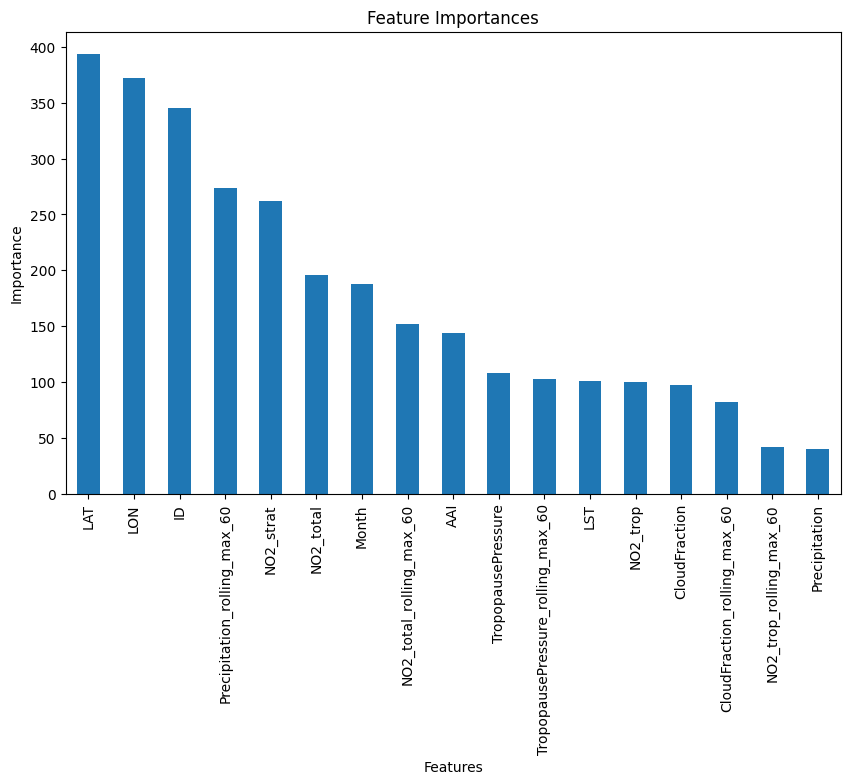

In [ ]:
importances = model.feature_importances_
names = model.feature_name_
fi = pd.DataFrame({'Feature': names,
                   'importances': importances})
fi = fi.sort_values(by='importances', ascending=False)

fi.plot(kind='bar', x='Feature', y='importances', legend=False, figsize=(10, 6))
plt.title('Feature Importances')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

In [ ]:
names

['ID',
 'LAT',
 'LON',
 'Precipitation',
 'LST',
 'AAI',
 'CloudFraction',
 'NO2_strat',
 'NO2_total',
 'NO2_trop',
 'TropopausePressure',
 'Month',
 'NO2_trop_rolling_max_60',
 'NO2_total_rolling_max_60',
 'TropopausePressure_rolling_max_60',
 'CloudFraction_rolling_max_60',
 'Precipitation_rolling_max_60']